In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

In [2]:
import math
import plotnine as p9
import pandas as pd
from sklearn.decomposition import PCA
import pickle as pkl
import yaml
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pyvene as pv
from collections import defaultdict, Counter

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [3]:
from tinylang.language import Language, PCFG
from tinylang.model import Model, Llama
from tinylang.experiment import TrainingConfig, Experiment
from tinylang.eval import SummaryEvaluator, InterchangeEvaluator

In [34]:
config_file = 'configs/llama.yaml'

filename = os.path.basename(config_file)
config_path = config_file.split("configs/")[1].split(".")[0]

with open(config_file, 'r') as f:
    config = yaml.safe_load(f)
    config["training"]["log_dir"] = os.path.join('.', f"logs/{config_path}")
# config['verbose'] = True

In [35]:
device = torch.device("cpu")
config['model']['config']['device'] = 'cpu'

In [36]:
experiment = Experiment.from_config(config)

Model size: 531584


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.


In [37]:
experiment.train()

             PARENT.query_item.pred_prob: 3.86873%
                    query_item.pred_prob: 3.86873%
                         0.PARENT.query_item_orig.divider.attention_input.kl_div: 0.00000
                             0.PARENT.query_item_orig.divider.block_input.kl_div: 0.00000
                      0.PARENT.query_item_orig.query_item.attention_input.kl_div: 0.00000
                          0.PARENT.query_item_orig.query_item.block_input.kl_div: 0.00000
                     0.PARENT.query_item_orig.target_item.attention_input.kl_div: 0.00000
                    0.PARENT.query_item_orig.target_item.attention_output.kl_div: 0.00000
                         0.PARENT.query_item_orig.target_item.block_input.kl_div: 0.00000
                        0.PARENT.query_item_orig.target_item.block_output.kl_div: 0.00000
                0.PARENT.query_item_orig.target_item_orig.attention_input.kl_div: 0.00000
               0.PARENT.query_item_orig.target_item_orig.attention_output.kl_div: 0.0000

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ./logs/llama/SummaryEvaluator.loss.png
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ./logs/llama/SummaryEvaluator.PARENT.query_item.kl_div.png
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/ggplot.py:610: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/ggplot.py:611: PlotnineWarning: Filename: ./logs/llama/SummaryEvaluator.query_item.kl_div.png
/Library/Fram

In [38]:
model = Llama.from_pretrained('logs/llama/model.pt')
with open('logs/llama/language.pkl', 'rb') as f:
    language = pkl.load(f)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.


In [73]:
n = 128
all_activations = []

for _ in range(n):
    
    tokens, probing_schema = language.sample()

    for layer in range(model.n_layer):
        
        pv_config = pv.IntervenableConfig({
            "layer": layer,
            "component": "block_input",
            "intervention_type": pv.CollectIntervention}
        )
        pv_gpt2 = pv.IntervenableModel(pv_config, model=model.model)

        for item in ['query', 'target']:

            item_position = probing_schema['queries'][f'{item}_item']['pos']
            embedding = []
            token_probs = []

            for token in range(language.vocab_size):
                
                input_tensor = torch.tensor(tokens, dtype=torch.int32)
                input_tensor[item_position] = token
                inputs = {'input_ids' : input_tensor.unsqueeze(0)}

                # probability of token
                token_probs.append(
                    float(F.softmax(
                        model.model(input_tensor.unsqueeze(0)).logits, dim=2
                    )[0][item_position][token].item())
                )
                
                collected_activations = pv_gpt2(
                    base = inputs,
                    unit_locations={"sources->base": item_position}
                )[0][-1][0]
                
                embedding.append(collected_activations)

            token = torch.tensor(tokens, dtype=torch.int32)[item_position]
            token_array = np.zeros(language.vocab_size)
            token_array[token] = 1
            
            all_activations.append({
                'layer' : language.vocab_size * [layer],
                'item'  : language.vocab_size * [item],
                'token' : token_array.astype(bool).tolist(),
                'probs' : token_probs,
                'embd'  : torch.stack(embedding).squeeze(1)
            })

In [74]:
pca = PCA(n_components=5)

In [75]:
cols = ['layer', 'item', 'token', 'probs']
df = (
    pd.DataFrame(all_activations)
      .drop(columns='embd')
      .explode(cols)
      .reset_index(drop=True)
)

In [76]:
all_pca = []

for item in all_activations:
    all_pca.append(pca.fit_transform(item['embd']))

df[['pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5']] = np.vstack(all_pca)[:, :5]
df['probs'] = pd.to_numeric(df['probs'], errors='raise')

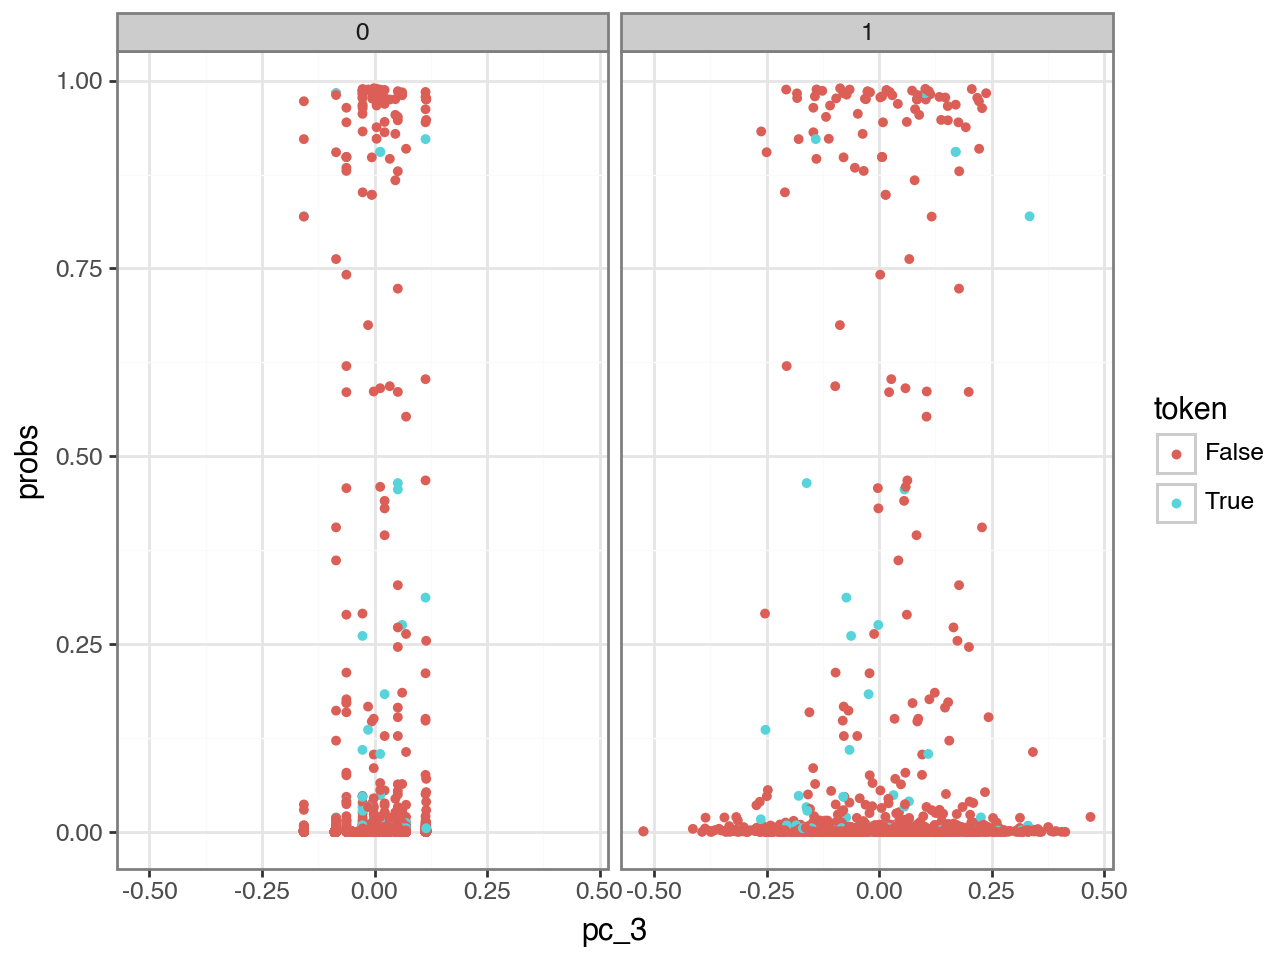

In [89]:
(
    p9.ggplot(df[df['item'] == 'query'], p9.aes(x='pc_3', y='probs', color='token'))
    + p9.geom_point(size=1)
    + p9.facet_wrap('~layer')
    + p9.theme_bw()
)

In [44]:
pca.explained_variance_ratio_

array([0.22928734, 0.1094609 , 0.09930971, 0.06775434, 0.06204852])